# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
from datetime import date, datetime, timedelta
import time
hoje = datetime.today().strftime('%d/%m/%Y')
time.asctime( time.localtime(time.time()) )

'Fri Oct 25 13:05:39 2024'

In [2]:
import pandas as pd
from ipywidgets import IntProgress
import ipywidgets as widgets
import json
from bs4 import BeautifulSoup
pd.__version__

'1.3.4'

In [3]:
from IPython.display import FileLink, FileLinks, display, clear_output, Markdown
FileLink('Resultados.ipynb')

C:\Users\F0435280\OneDrive - Banco do Brasil S.A\Área de Trabalho\Alexandre\StockManager-main\Resultados.ipynb

In [4]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
from pacote.functions import *

In [6]:
ano = time.localtime().tm_year
if time.localtime().tm_mon < 3:
    str_ano, str_nov_ant, str_dez_ant = f'A{ano}', f'M11{ano-1}', f'M12{ano-1}'
    LISTA_ARQUIVOS = [str_ano, str_nov_ant, str_dez_ant]
else:
    str_ano = f'A{ano}'
    LISTA_ARQUIVOS = [str_ano]

In [7]:
df = carrega_dados(LISTA_ARQUIVOS)

In [8]:
# Monday is 0 and Sunday is 6.
dia_semana  = datetime.today().weekday()
ajuste_dias = -3 if dia_semana == 0 else -1
dt_esperado_ult = (datetime.today() + timedelta(days=ajuste_dias)).strftime('%Y-%m-%d')
dt_max = str(df["dtPregao"].max()).split()[0]

if dt_esperado_ult == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)
def printmd(string):
    display(Markdown(string))

In [9]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech

style, layout, max_count, parm_vol = {'description_width':'initial'}, {'width':'400px'}, 7, 6000000
bar = IntProgress(min=0, max=max_count, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 24, 1, bar)
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 19, 1, bar)
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 1, bar)
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 9, 1, bar)
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 1, bar)
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 1, bar)
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 1, bar)
merge1 = pd.merge(d25['Acao'], d20['Acao'], how ='inner', on =['Acao'])
merge2 = pd.merge(merge1, d15['Acao'], how ='inner', on =['Acao'])
merge3 = pd.merge(merge2, d10['Acao'], how ='inner', on =['Acao'])
merge_final = pd.merge(merge3, d05['Acao'], how ='inner', on =['Acao'])
if merge_final.empty:
    merge_final = "<< Sem ações boas em todo o período >>"

IntProgress(value=0, layout=Layout(width='400px'), max=7, style=ProgressStyle(description_width='initial'))

In [10]:
if len(d05) > 5:
    df_button = d05
    print("d05")
elif len(d04) > 5:
    df_button = d04
    print("d04")
else:
    df_button = d03
    print("d03")

button0 = widgets.Button(description=f'{"0-"}{df_button["Acao"].iloc[0]}') if df_button["Acao"].size > 0 else None
button1 = widgets.Button(description=f'{"1-"}{df_button["Acao"].iloc[1]}') if df_button["Acao"].size > 1 else None
button2 = widgets.Button(description=f'{"2-"}{df_button["Acao"].iloc[2]}') if df_button["Acao"].size > 2 else None
button3 = widgets.Button(description=f'{"3-"}{df_button["Acao"].iloc[3]}') if df_button["Acao"].size > 3 else None
button4 = widgets.Button(description=f'{"4-"}{df_button["Acao"].iloc[4]}') if df_button["Acao"].size > 4 else None
button5 = widgets.Button(description=f'{"5-"}{df_button["Acao"].iloc[5]}') if df_button["Acao"].size > 5 else None
button6 = widgets.Button(description=f'{"6-"}{df_button["Acao"].iloc[6]}') if df_button["Acao"].size > 6 else None
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        index = int(b.description[0])
        display(consulta_acao_formatada(df, df_button['Acao'].iloc[index]))

lista_buttons = []
if button0:
    button0.on_click(on_button_clicked)
    lista_buttons.append(button0)
if button1:
    button1.on_click(on_button_clicked)
    lista_buttons.append(button1)
if button2:
    button2.on_click(on_button_clicked)
    lista_buttons.append(button2)
if button3:
    button3.on_click(on_button_clicked)
    lista_buttons.append(button3)
if button4:
    button4.on_click(on_button_clicked)
    lista_buttons.append(button4)
if button5:
    button5.on_click(on_button_clicked)
    lista_buttons.append(button5)
if button6:
    button6.on_click(on_button_clicked)
    lista_buttons.append(button6)

d05


In [11]:
ativos_dividendos_hoje = busca_ativos_dividendos()
ativos_dividendos_hoje

set()

In [12]:
# Setando definição de cores
def color_red_dividend(val):
    color = 'red' if val in ativos_dividendos_hoje else 'black'
    return 'color: %s' % color

In [13]:
d25_format = d25.style.applymap(color_red_dividend, subset=['Acao'])
d20_format = d20.style.applymap(color_red_dividend, subset=['Acao'])
d15_format = d15.style.applymap(color_red_dividend, subset=['Acao'])
d10_format = d10.style.applymap(color_red_dividend, subset=['Acao'])
d05_format = d05.style.applymap(color_red_dividend, subset=['Acao'])
d04_format = d04.style.applymap(color_red_dividend, subset=['Acao'])
d03_format = d03.style.applymap(color_red_dividend, subset=['Acao'])
d25_format = d25_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d20_format = d20_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d15_format = d15_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d10_format = d10_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d05_format = d05_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d04_format = d04_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d03_format = d03_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})

In [14]:
printmd(f'**<div class={font_color}>{hoje}, Arquivo {a}</div>**')

**<div class=alert-success>25/10/2024, Arquivo Atualizado!</div>**

### 25 dias, order by 1%

In [15]:
d25_format if not d25.empty else print('<< Sem ações boas para 25 dias >>')

<< Sem ações boas para 25 dias >>


### 20 dias, order by 1%

In [16]:
d20_format if not d20.empty else print('<< Sem ações boas para 20 dias >>')

<< Sem ações boas para 20 dias >>


### 15 dias, order by 1%

In [17]:
d15_format if not d15.empty else print('<< Sem ações boas para 10 dias >>')

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1617,QUAL3,15,14,12,11,8,6,66,"10,153,993.87",2.15,-0.09


### 10 dias, order by 1%

In [18]:
d10_format if not d10.empty else print('<< Sem ações boas para 10 dias >>')

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1634,RCSL4,10,10,10,10,10,10,60,"7,257,961.80",1.55,1.20
1282,M2ST34,9,9,9,9,7,7,50,"25,070,796.43",17.03,1.52
2081,YDUQ3,9,9,9,8,7,4,46,"48,324,100.10",10.48,-0.18
1337,MOVI3,9,9,8,7,6,6,45,"26,962,167.80",5.77,-0.24
1966,VAMO3,9,9,9,7,6,5,45,"59,785,829.80",5.94,-0.34
108,AMBP3,10,9,7,6,6,4,42,"31,140,477.30",134.53,0.45
596,COGN3,9,9,8,7,5,4,42,"41,372,478.50",1.38,-0.14
1671,ROXO34,10,9,8,7,5,3,42,"33,575,602.09",13.51,0.67
128,ASAI3,9,9,9,8,3,3,41,"161,794,636.70",7.14,0.30
1581,QUAL3,10,9,7,6,4,4,40,"9,695,272.70",2.20,-0.13


### 5 dias, order by 1%

In [19]:
d05_format

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1553,RCSL4,5,5,5,5,5,5,30,"9,563,666.60",1.77,1.48
1671,SEQL3,5,5,5,5,5,5,30,"16,375,420.40",4.17,1.34
1875,VAMO3,5,5,5,4,4,3,26,"66,358,325.20",6.15,-0.52
1987,YDUQ3,5,5,5,4,4,3,26,"52,242,252.80",10.59,-0.09
124,ASAI3,5,5,5,5,2,2,24,"142,430,125.80",7.27,-0.22
556,COGN3,5,5,4,4,3,2,23,"41,053,481.40",1.40,-0.14
1680,SIMH3,5,5,5,3,2,2,22,"13,899,717.20",5.21,-0.46
1270,MOVI3,5,5,4,3,2,2,21,"21,363,461.20",5.81,-0.31
104,AMBP3,5,5,3,2,2,1,18,"22,146,398.60",133.28,0.22
1503,QUAL3,5,5,3,3,1,1,18,"8,552,255.20",2.16,-0.18


In [20]:
d04_format

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1528,RCSL4,4,4,4,4,4,4,24,"9,846,100.25",1.75,1.16
1643,SEQL3,4,4,4,4,4,4,24,"18,520,048.75",4.34,1.44
1846,VAMO3,4,4,4,4,4,3,23,"69,319,082.50",6.24,-0.78
1958,YDUQ3,4,4,4,4,4,3,23,"57,035,077.25",10.67,-0.19
550,COGN3,4,4,4,4,3,2,21,"43,280,814.00",1.41,-0.36
121,ASAI3,4,4,4,4,2,2,20,"132,770,807.25",7.31,-0.41
1652,SIMH3,4,4,4,3,2,2,19,"14,413,301.50",5.24,-0.58
1250,MOVI3,4,4,3,3,2,2,18,"20,217,974.00",5.85,-0.48
1480,QUAL3,4,4,2,2,1,1,14,"8,067,293.75",2.17,-0.34
102,AMBP3,4,4,2,1,1,1,13,"18,965,891.25",133.15,0.55


In [21]:
d03_format

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1470,RCSL4,3,3,3,3,3,3,18,"9,110,642.00",1.68,0.81
1583,SEQL3,3,3,3,3,3,3,18,"22,503,904.67",4.59,1.54
1783,VAMO3,3,3,3,3,3,2,17,"76,140,264.00",6.30,-0.98
1891,YDUQ3,3,3,3,3,3,2,17,"56,436,673.67",10.73,-0.35
531,COGN3,3,3,3,3,2,2,16,"47,147,667.00",1.42,-0.48
1591,SIMH3,3,3,3,3,2,2,16,"14,703,045.00",5.27,-0.77
1332,PCAR3,3,3,2,2,2,2,14,"40,971,805.67",3.26,-0.22
115,ASAI3,3,3,3,3,1,1,14,"128,059,222.33",7.34,-0.69
1202,MOVI3,3,3,2,2,1,1,12,"21,064,890.67",5.85,-0.63
1692,TGMA3,3,3,3,1,1,1,12,"13,361,021.67",28.80,0.15


In [22]:
printmd(f'**<div class={font_color}>{hoje}, Status {a}</div>**')

**<div class=alert-success>25/10/2024, Status Atualizado!</div>**

## Consulta ação específica

In [23]:
consulta_acao_formatada(df, "irbr3")

,Acao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,05,10,15,20,25,30
346654,IRBR3,2024-10-24,44.22,"128,218,028",48.45,44.22,47.91,-7.32%,1.55%,-7.32%,0.42%,1,1,1,,,
345090,IRBR3,2024-10-23,47.71,"154,963,938",48.15,42.68,42.80,12.29%,13.32%,0.45%,0.73%,1,1,1,1,1,1
343320,IRBR3,2024-10-22,42.49,"25,539,093",42.53,41.59,42.45,0.07%,0.16%,-2.05%,-0.02%,,,,,,
341610,IRBR3,2024-10-21,42.46,"28,485,513",42.56,41.61,41.86,1.94%,2.18%,-0.10%,0.50%,1,1,1,1,,
339977,IRBR3,2024-10-18,41.65,"28,390,128",42.46,41.35,42.13,-0.93%,1.00%,-1.64%,0.21%,1,,,,,
338222,IRBR3,2024-10-17,42.04,"47,524,183",43.14,41.91,43.14,-2.84%,-0.30%,-3.14%,-0.30%,,,,,,
336662,IRBR3,2024-10-16,43.27,"46,112,822",44.04,43.03,43.80,-1.66%,0.09%,-2.20%,-0.45%,,,,,,
334886,IRBR3,2024-10-15,44.00,"32,310,353",44.46,43.53,43.87,nan%,1.05%,-1.07%,-0.30%,1,1,,,,
333244,IRBR3,2024-10-14,44.00,"43,296,265",44.31,43.10,43.39,1.22%,1.93%,-0.85%,-0.18%,1,1,1,,,
331475,IRBR3,2024-10-11,43.47,"26,629,095",43.69,42.73,43.15,0.58%,1.09%,-1.13%,-0.16%,1,1,,,,


In [24]:
buttons = widgets.HBox(lista_buttons)
widgets.VBox([buttons, output])

## Ações presentes em todos os períodos

In [25]:
merge_final

'>> Sem ações boas em todo o período <<'

## Grandes Variações de Volume

In [26]:
grandes_variacoes_volume(df)

'<< Sem ações com Grandes Variações de Volume >>'

In [27]:
try:
    df_json = pd.read_json("graficos.json")
    df_json = df_json.set_index("data")
except:
    df_json = pd.DataFrame()

In [28]:
list_datas, list_datas_dt, d05_count, d10_count, d15_count, d20_count, d25_count = [], [], [], [], [], [], []
df_temp, d05_temp, d10_temp, d15_temp, d20_temp, d25_temp =  df.copy(), d05.copy(), d10.copy(), d15.copy(), d20.copy(), d25.copy()
max_count = 20

bar = IntProgress(min=0, max=max_count*5, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

for i in range(0, max_count):
    dt_max = df_temp["dtPregao"].max()
    dt_max_str = str(dt_max)[0:10]
    list_datas.append(dt_max_str)
    
    if df_json.loc[(df_json.index == dt_max_str)].empty:
        d05_count.append(len(d05_temp))
        d10_count.append(len(d10_temp))
        d15_count.append(len(d15_temp))
        d20_count.append(len(d20_temp))
        d25_count.append(len(d25_temp))

        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
        d05_temp = monta_tabela(monta_df_periodos(df_temp, 5), 3000000, '1.0%', 5, 1, bar)
        d10_temp = monta_tabela(monta_df_periodos(df_temp, 10), 3000000, '1.0%', 9, 1, bar)
        d15_temp = monta_tabela(monta_df_periodos(df_temp, 15), 3000000, '1.0%', 14, 1, bar)
        d20_temp = monta_tabela(monta_df_periodos(df_temp, 20), 3000000, '1.0%', 18, 1, bar)
        d25_temp = monta_tabela(monta_df_periodos(df_temp, 25), 3000000, '1.0%', 22, 1, bar)
    else:
        d05_count.append(df_json.loc[dt_max_str]["qt_acoes_05"])
        d10_count.append(df_json.loc[dt_max_str]["qt_acoes_10"])
        d15_count.append(df_json.loc[dt_max_str]["qt_acoes_15"])
        d20_count.append(df_json.loc[dt_max_str]["qt_acoes_20"])
        d25_count.append(df_json.loc[dt_max_str]["qt_acoes_25"])
        
        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
    
        bar.value += 5 # signal to increment the progress bar

IntProgress(value=0, layout=Layout(width='400px'), style=ProgressStyle(description_width='initial'))

In [29]:
# df_temp.dtPregao

In [30]:
df_graficos = pd.DataFrame({'data': list_datas, \
                            'qt_acoes_05': d05_count, \
                            'qt_acoes_10': d10_count, \
                            'qt_acoes_15': d15_count, \
                            'qt_acoes_20': d20_count, \
                            'qt_acoes_25': d25_count  
                           })
df_graficos.to_json("graficos.json")

### Gráfico 05

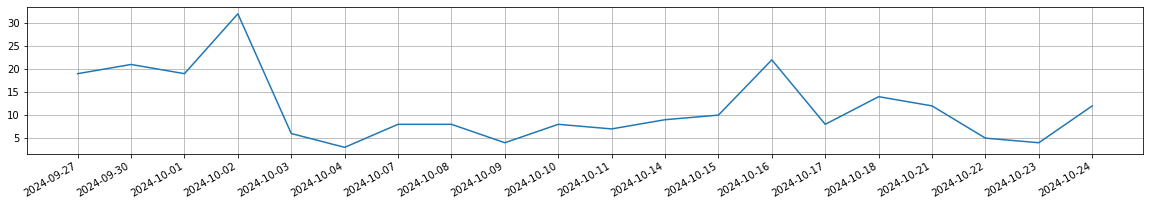

In [31]:
# gera_grafico(list_datas, d05_count)
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_05'])

### Gráfico 10

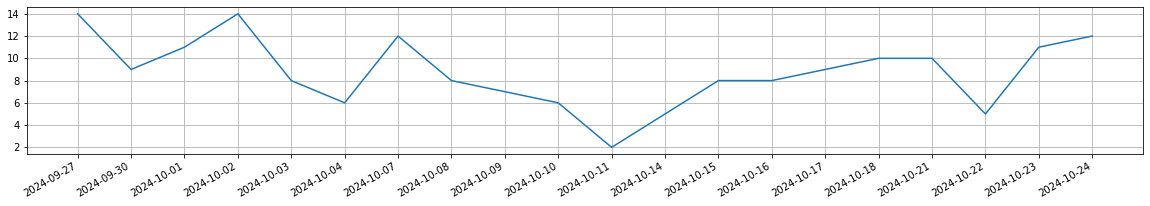

In [32]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_10'])

### Gráfico 15

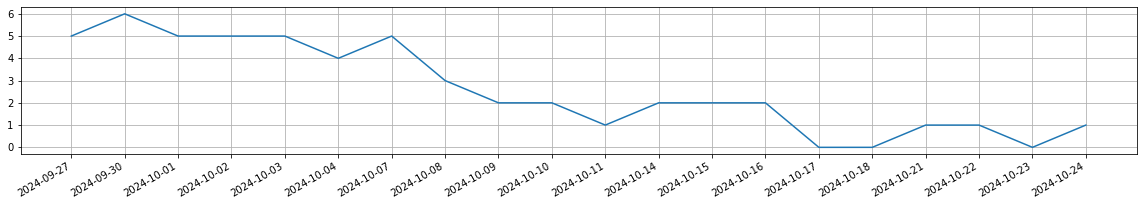

In [33]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_15'])

### Gráfico 20

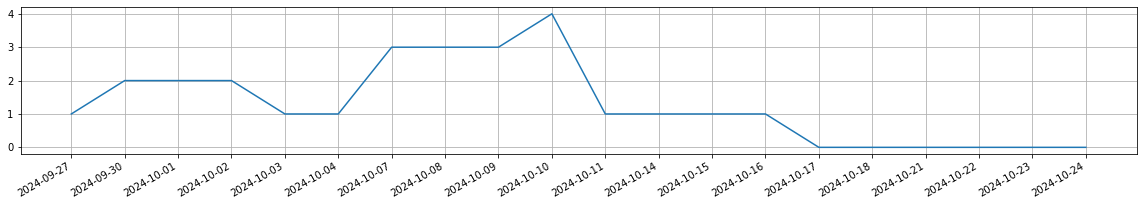

In [34]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_20'])

### Gráfico 25

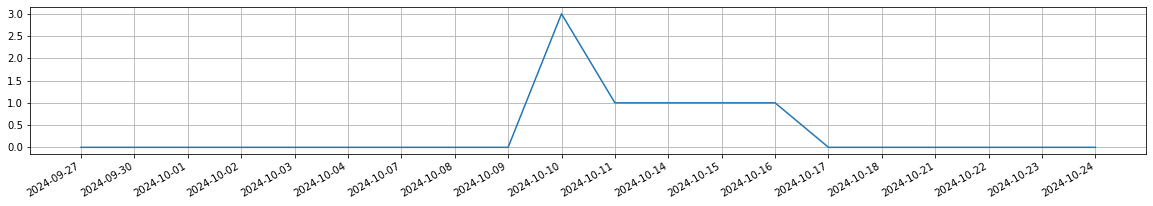

In [35]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_25'])